In [ ]:
import pandas as pd
import numpy as np
import math
import drms
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor,
                              RandomForestClassifier, GradientBoostingClassifier)
from sklearn.svm import SVR, SVC
from sklearn.metrics import (accuracy_score, mean_squared_error, r2_score, mean_absolute_error,
                             precision_score, recall_score, f1_score, confusion_matrix)

import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [7]:
client = drms.Client()

In [8]:
series = 'hmi.sharp_cea_720s'

In [ ]:
start_date = datetime(2010, 1, 1)
end_date = datetime(2023, 12, 31)

df = pd.DataFrame()

current_date = start_date
while current_date <= end_date:
  date_range = f'{current_date.strftime("%Y.%m.%d_TAI")}'
  
  query_string = f'{series}[][{date_range}]'
  result = client.query(query_string, key=client.keys(series))
  
  _tmp_df = pd.DataFrame(result)
  df = pd.concat([df, _tmp_df], ignore_index=True)
  
  # Move to the next day
  current_date = current_date + timedelta(days=1)

df.to_csv(f"{series}.csv", index=False)

In [ ]:
series_info = client.info(series)
for keyword in series_info.keywords.index:
  keyword_info = series_info.keywords.loc[keyword]
  print(keyword_info.name)
  print(f"  type ....... {keyword_info.type} ")
  print(f"  recscope ... {keyword_info.recscope} ")
  print(f"  defval ..... {keyword_info.defval} ")
  print(f"  units ...... {keyword_info.units} ")
  print(f"  note ....... {keyword_info.note} ")
  print("\n")

# Reload df

In [105]:
df = pd.read_csv(f"{series}.csv", low_memory=False)

In [106]:
df.head()

,cparms_sg000,magnetogram_bzero,magnetogram_bscale,cparms_sg001,bitmap_bzero,bitmap_bscale,cparms_sg002,Dopplergram_bzero,Dopplergram_bscale,cparms_sg003,...,CMASK,ERRJZ,ERRVF,ERRALP,ERRMIH,ERRMSHA,ERRUSI,DOFFSET,ERRTPOT,ERRJHT
0,compress Rice,0,0.1,MISSING,0,1,compress Rice,0,0.5,compress Rice,...,9758.0,0.057597,5.330796e+18,0.001069,0.000355,0.000,7.464025e+10,50,6.703020e+19,3.000382e+11
1,compress Rice,0,0.1,MISSING,0,1,compress Rice,0,0.5,compress Rice,...,2517.0,0.172348,1.886162e+18,0.003040,0.001354,0.014,5.761051e+10,50,5.336194e+19,2.315822e+11
2,compress Rice,0,0.1,MISSING,0,1,compress Rice,0,0.5,compress Rice,...,1027.0,0.371506,1.205937e+18,0.009346,0.002182,0.037,5.066977e+10,50,3.566657e+19,2.036819e+11
3,compress Rice,0,0.1,MISSING,0,1,compress Rice,0,0.5,compress Rice,...,1117.0,0.336182,1.264269e+18,0.008195,0.001984,0.128,4.987003e+10,50,3.530184e+19,2.004671e+11
4,compress Rice,0,0.1,MISSING,0,1,compress Rice,0,0.5,compress Rice,...,11137.0,0.046605,4.358624e+18,0.000901,0.000272,0.011,6.893109e+10,50,4.211002e+19,2.772309e+11


In [108]:
df.shape

(32681, 215)

In [109]:
# Drop if column has the same value for all rows
def find_uniform_columns(_df):
  _uniform_columns = {}
  
  for column in _df.columns:
    # Check if the column has the same value for all rows
    if _df[column].nunique() < 2:
      _uniform_columns[column] =_df[column].unique()[0]
  
  return _uniform_columns
uniform_columns_dict = find_uniform_columns(df)
uniform_columns_dict

{'cparms_sg000': 'compress Rice',
 'magnetogram_bzero': 0,
 'magnetogram_bscale': 0.1,
 'cparms_sg001': 'MISSING',
 'bitmap_bzero': 0,
 'bitmap_bscale': 1,
 'cparms_sg002': 'compress Rice',
 'Dopplergram_bzero': 0,
 'Dopplergram_bscale': 0.5,
 'cparms_sg003': 'compress Rice',
 'continuum_bzero': 97304,
 'continuum_bscale': 3,
 'cparms_sg004': 'compress Rice',
 'Bp_bzero': 0,
 'Bp_bscale': 0.01,
 'cparms_sg005': 'compress Rice',
 'Bt_bzero': 0,
 'Bt_bscale': 0.01,
 'cparms_sg006': 'compress Rice',
 'Br_bzero': 0,
 'Br_bscale': 0.01,
 'cparms_sg007': 'compress Rice',
 'Bp_err_bzero': 0,
 'Bp_err_bscale': 0.001,
 'cparms_sg008': 'compress Rice',
 'Bt_err_bzero': 0,
 'Bt_err_bscale': 0.001,
 'cparms_sg009': 'compress Rice',
 'Br_err_bzero': 0,
 'Br_err_bscale': 0.001,
 'cparms_sg010': 'compress Rice',
 'conf_disambig_bzero': 0,
 'conf_disambig_bscale': 1,
 'T_REC_epoch': '1993.01.01_00:00:00_TAI',
 'T_REC_step': 720.0,
 'T_REC_unit': 'secs',
 'CADENCE': 720.0,
 'GWILL': nan,
 'CTYPE1': 'CR

In [110]:
df.drop([key for key, val in uniform_columns_dict.items()], axis=1, inplace=True)
df.shape

(32681, 132)

In [111]:
df.describe().drop(['count', '25%', '50%', '75%', 'std'])

/home/debashis/works/dissertation/env/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/debashis/works/dissertation/env/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/debashis/works/dissertation/env/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,USFLUX,MEANGAM,MEANGBT,MEANGBZ,MEANGBH,MEANJZD,TOTUSJZ,MEANALP,MEANJZH,TOTUSJH,...,CMASK,ERRJZ,ERRVF,ERRALP,ERRMIH,ERRMSHA,ERRUSI,DOFFSET,ERRTPOT,ERRJHT
mean,7.196431e+21,33.485017,111.268217,113.384456,48.79942,0.166253,8.990573e+12,-0.000346,-0.000127,445.30288,...,11141.426425,0.276794,3.201826e+18,0.007240,0.001821,inf,8.690126e+10,49.919219,1.125121e+20,3.443617e+11
min,0.000000e+00,11.067000,9.394000,9.345000,7.21100,-13.483965,0.000000e+00,-0.453582,-0.086871,0.00000,...,0.000000,0.014009,0.000000e+00,0.000305,0.000092,0.0,0.000000e+00,20.000000,0.000000e+00,0.000000e+00
max,2.064290e+23,76.516000,265.285000,261.275000,200.88900,16.448557,2.396615e+14,1.404680,0.087096,14252.40200,...,271015.000000,27.276052,3.973213e+19,1.254809,0.145767,inf,1.282146e+12,50.000000,1.312725e+22,4.932344e+12


In [112]:
drop_col_datelike = [col for col in df.columns if col.startswith('DATE')]
drop_col_tlike = [col for col in df.columns if col.startswith('T_') and col != 'T_REC']

df.drop(drop_col_tlike + drop_col_datelike, axis=1, inplace=True)

In [113]:
def columns_with_unique_counts(_df):
  unique_counts = []
  
  for column in _df.columns:
    unique_value_count = _df[column].nunique()
    unique_counts.append((column, unique_value_count))
  
  return np.array(unique_counts)
columns_with_unique_counts(df)

array([['T_REC', '4451'],
       ['USFLUX', '32286'],
       ['MEANGAM', '18445'],
       ['MEANGBT', '27533'],
       ['MEANGBZ', '27425'],
       ['MEANGBH', '24297'],
       ['MEANJZD', '32316'],
       ['TOTUSJZ', '32289'],
       ['MEANALP', '32256'],
       ['MEANJZH', '32088'],
       ['TOTUSJH', '30853'],
       ['ABSNJZH', '21490'],
       ['SAVNCPP', '32285'],
       ['MEANPOT', '32158'],
       ['TOTPOT', '32293'],
       ['MEANSHR', '17094'],
       ['SHRGT45', '17226'],
       ['R_VALUE', '3486'],
       ['CRPIX1', '1136'],
       ['CRPIX2', '687'],
       ['CRVAL1', '32660'],
       ['CRVAL2', '5266'],
       ['IMCRPIX1', '4313'],
       ['IMCRPIX2', '4250'],
       ['DSUN_OBS', '4451'],
       ['CRLN_OBS', '4451'],
       ['CRLT_OBS', '4449'],
       ['CAR_ROT', '183'],
       ['OBS_VR', '4451'],
       ['OBS_VW', '4451'],
       ['OBS_VN', '4451'],
       ['RSUN_OBS', '4402'],
       ['INSTRUME', '2'],
       ['CAMERA', '2'],
       ['QUALITY', '18'],
       ['QUAL_S', 

In [114]:
df['T_REC'] = df['T_REC'].apply(lambda _dt: (pd.to_datetime(_dt, format='%Y.%m.%d_%H:%M:%S_TAI')).date())

In [115]:
null_counts = df.isnull().sum()
null_counts[null_counts != 0]

MEANGAM        368
MEANGBT        359
MEANGBZ        359
MEANGBH        359
MEANJZD        359
MEANALP        359
MEANJZH        359
MEANPOT        359
MEANSHR        399
SHRGT45        359
R_VALUE         18
NPIX           208
SIZE           208
AREA           208
NACR           208
SIZE_ACR       208
AREA_ACR       208
MTOT           208
MNET           208
MPOS_TOT       208
MNEG_TOT       208
MMEAN          208
MSTDEV         208
MSKEW          208
MKURT          208
LAT_MIN        208
LON_MIN        208
LAT_MAX        208
LON_MAX        208
LAT_FWT        237
LON_FWT        237
LAT_FWTPOS    5608
LON_FWTPOS    5608
LAT_FWTNEG    5804
LON_FWTNEG    5804
INVBLAVE       209
MEANGBL        209
AMBPATCH       256
AMBWEAK        256
ERRGAM         368
ERRBH          359
ERRMPOT        359
ERRBT          359
ERRBZ          359
ERRJZ          360
ERRALP         359
ERRMIH         359
ERRMSHA        649
ERRUSI           1
dtype: int64

In [116]:
df['QUALITY'].value_counts()

QUALITY
0        30459
128       1556
4096       238
1024       149
66560       96
32          47
65536       46
4224        22
67584       11
1152        11
68608       11
1056        10
70656        8
66688        6
70784        5
65664        4
72832        1
69632        1
Name: count, dtype: int64

In [117]:
# Filters by quality
df = df[df['QUALITY'] < 4300]

In [119]:
drop_col = (['INSTRUME', 'CAMERA','QUALITY', 'QUAL_S', 'QUALLEV1',
            'HISTORY', 'BLD_VERS', 'CALVER64', 'CODEVER7',
            'INVCODEV', 'AMBCODEV', 'NOAA_NUM']) #'INVPHMAP'
df.drop(drop_col, axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,T_REC,USFLUX,MEANGAM,MEANGBT,MEANGBZ,MEANGBH,MEANJZD,TOTUSJZ,MEANALP,MEANJZH,...,CMASK,ERRJZ,ERRVF,ERRALP,ERRMIH,ERRMSHA,ERRUSI,DOFFSET,ERRTPOT,ERRJHT
0,2010-05-02,7.284643e+21,23.882,72.810,75.884,31.044,-0.083294,5.949744e+12,-0.005115,-0.001544,...,11137.0,0.046605,4.358624e+18,0.000901,0.000272,0.011,6.893109e+10,50,4.211002e+19,2.772309e+11
1,2010-05-02,7.577038e+20,33.088,155.084,157.227,75.352,1.176815,1.200310e+12,-0.040246,-0.015144,...,1077.0,0.356616,1.211761e+18,0.006817,0.002565,0.121,5.100690e+10,50,3.953265e+19,2.051424e+11
2,2010-05-02,3.994556e+20,28.103,142.582,143.811,50.887,0.572461,5.667294e+11,0.013079,0.003529,...,638.0,0.366033,8.773581e+17,0.008784,0.002370,0.171,3.101368e+10,50,2.219341e+19,1.247325e+11
3,2010-05-02,7.155764e+20,28.317,138.661,140.604,50.574,0.357809,1.123229e+12,-0.012548,-0.003167,...,1182.0,0.313383,1.341280e+18,0.007388,0.001864,0.105,4.919330e+10,50,3.527319e+19,1.978483e+11
4,2010-05-05,5.300906e+21,29.565,119.300,117.777,46.557,0.219137,7.221955e+12,-0.002556,-0.000673,...,8780.0,0.094013,3.719263e+18,0.002217,0.000584,0.018,1.096212e+11,50,8.449323e+19,4.415520e+11


In [ ]:
# drop_col_others = ['HFLID', 'HCFTID', 'HARPNUM', 'LATDTMIN', 'LONDTMIN', 'LATDTMAX', 'LONDTMAX']
# drop_col_obs_param2 = ['OBS_VR', 'OBS_VW', 'OBS_VN']
# drop_col_img_param = ['CRPIX1', 'CRPIX2', 'CRVAL1', 'CRVAL2', 'IMCRPIX1', 'IMCRPIX2']
# drop_sun_obs_param = ['DSUN_OBS', 'CRLN_OBS', 'CRLT_OBS', 'CAR_ROT', 'RSUN_OBS']  # todo: might be useful
# 
# df.drop(drop_col_others + drop_col_obs_param2 + drop_col_img_param + drop_sun_obs_param,
#         axis=1, inplace=True)
# df.reset_index(drop=True, inplace=True)
# df.head()

In [120]:
df = df[df['NOAA_AR'] != 0].reset_index(drop=True)
df.shape

(18495, 109)

### Not using ARS, instead using _AR

In [152]:
# df['NOAA_ARS'] = df['NOAA_ARS'].str.split(',')

# # Explode the NOAA_ARS column to create separate rows for each value
# df = df.explode('NOAA_ARS').reset_index(drop=True)
# df.shape

(24701, 88)

## Calculate error separately

In [159]:
# err_column_pairs = [('MEANGAM', 'ERRGAM'),  # Mean inclination angle, gamma
#                     ('MEANPOT', 'ERRMPOT'),('TOTPOT', 'ERRTPOT'), # photospheric excess magnetic energy density
#                     ('MEANGBT', 'ERRBT'), ('MEANGBH', 'ERRBH'), ('MEANGBZ', 'ERRBZ'), # field gradient
#                     ('MEANJZD', 'ERRJZ'),   # Mean vertical current density
#                     ('MEANALP', 'ERRALP'),  # Mean twist parameter, alpha
#                     ('MEANSHR', 'ERRMSHA'), # Mean shear angle for B_total
#                     ('TOTUSJZ', 'ERRUSI'), # Total unsigned vertical current
#                     ('SAVNCPP', 'ERRJHT')
#                     ]
# 
# for actual_col, error_col in err_column_pairs:
#   df[error_col] = df[error_col].fillna(0)
#   df[actual_col] = df[actual_col] - df[error_col]
#   df = df.drop(columns=[error_col])

In [161]:
# drop_col_unsigned_flux = ['USFLUX','USFLUXL','INVVLAVE','ERRVF']  # Got R-value (Schrijver, 2007)
# df.drop(drop_col_unsigned_flux, axis=1, inplace=True)
# df.shape

(24701, 73)

In [177]:
# drop_col_others3 = ['AMBNEQ', "ARM_QUAL","ARM_NCLN", 'H_MERGE', 'H_FAINT',
#                     'N_PATCH', 'N_PATCH1', 'N_PATCHM', 'NOAA_AR', 'NOAA_NUM']
# df.drop(drop_col_others3, axis=1, inplace=True)
# df.reset_index(drop=True, inplace=True)
# df.shape

(24701, 63)

In [179]:
set(['FlareNumber', 'T_REC', 'Longitude', 'Latitude', 'TOTUSJH', 'TOTBSQ',
       'TOTPOT', 'TOTUSJZ', 'ABSNJZH', 'SAVNCPP', 'USFLUX', 'AREA_ACR',
       'TOTFZ', 'MEANPOT', 'R_VALUE', 'EPSZ', 'SHRGT45', 'MEANSHR', 'MEANGAM',
       'MEANGBT', 'MEANGBZ', 'MEANGBH', 'MEANJZH', 'TOTFY', 'MEANJZD',
       'MEANALP', 'TOTFX', 'EPSY', 'EPSX'])-set(df.columns)

{'EPSX',
 'EPSY',
 'EPSZ',
 'FlareNumber',
 'Latitude',
 'Longitude',
 'TOTBSQ',
 'TOTFX',
 'TOTFY',
 'TOTFZ',
 'USFLUX'}

In [121]:
df.rename(columns={'NOAA_AR': 'Region', 'T_REC': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df['Region'] = df['Region'].astype(int)

## Keep this cleaned dataset

In [125]:
df.shape

(18495, 109)

In [124]:
# df.to_csv(f"../data/{series}_cleaned.csv", index=False)

In [128]:
df_flares = pd.read_csv("../data/flares-processed-2.csv")
df_flares = df_flares.dropna(subset=['Region', 'X-ray class'])
df_flares['Date'] = pd.to_datetime(df_flares[['Year', 'Month', 'Day']])
df_flares = df_flares.drop(['Start', 'End', 'Maximum',
                            'Year', 'Month', 'Day'], axis=1)
df_flares['Region'] = df_flares['Region'].astype(int)
df_flares.shape

(43115, 4)

In [129]:
df_flares.columns

Index(['Region', 'X-ray class', 'X-ray intensity', 'Date'], dtype='object')

In [130]:
df_merged = pd.merge(df, df_flares, on=['Region', 'Date'], how='left')
df_merged.shape

(25865, 111)

In [97]:
df_merged.head()

,Date,USFLUX,MEANGAM,MEANGBT,MEANGBZ,MEANGBH,MEANJZD,TOTUSJZ,MEANALP,MEANJZH,...,ERRVF,ERRALP,ERRMIH,ERRMSHA,ERRUSI,DOFFSET,ERRTPOT,ERRJHT,X-ray class,X-ray intensity
0,2010-05-02,7.284643e+21,23.882,72.810,75.884,31.044,-0.083294,5.949744e+12,-0.005115,-0.001544,...,4.358624e+18,0.000901,0.000272,0.011,6.893109e+10,50,4.211002e+19,2.772309e+11,B,2.9
1,2010-05-02,7.284643e+21,23.882,72.810,75.884,31.044,-0.083294,5.949744e+12,-0.005115,-0.001544,...,4.358624e+18,0.000901,0.000272,0.011,6.893109e+10,50,4.211002e+19,2.772309e+11,B,3.8
2,2010-05-02,7.577038e+20,33.088,155.084,157.227,75.352,1.176815,1.200310e+12,-0.040246,-0.015144,...,1.211761e+18,0.006817,0.002565,0.121,5.100690e+10,50,3.953265e+19,2.051424e+11,NaN,NaN
3,2010-05-02,7.155764e+20,28.317,138.661,140.604,50.574,0.357809,1.123229e+12,-0.012548,-0.003167,...,1.341280e+18,0.007388,0.001864,0.105,4.919330e+10,50,3.527319e+19,1.978483e+11,NaN,NaN
4,2010-05-05,5.300906e+21,29.565,119.300,117.777,46.557,0.219137,7.221955e+12,-0.002556,-0.000673,...,3.719263e+18,0.002217,0.000584,0.018,1.096212e+11,50,8.449323e+19,4.415520e+11,NaN,NaN


In [131]:
df_merged['X-ray class'] = df_merged['X-ray class'].fillna(0)
df_merged['X-ray class'].value_counts()

X-ray class
0    14338
C     6957
B     3684
M      825
X       51
A       10
Name: count, dtype: int64

In [132]:
# preparing Y
df_merged['X-ray Binary'] = df_merged['X-ray class'].map({
  0: 0, 'A': 0, 'B': 0, 'C': 0,
  'M': 1, 'X': 1,})

df_merged['X-ray Distinct'] = df_merged['X-ray class'].map({
  0: 0, 'A': 1, 'B': 2, 'C': 3, 'M': 4, 'X': 5,})

df_merged['X-ray Grouped'] = df_merged['X-ray class'].map({
  0: 0, 'A': 1, 'B': 1, 'C': 1, 'M': 2, 'X': 2,})

df_merged['X-ray All Flare'] = df_merged['X-ray class'].map({
  0: 0, 'A': 1, 'B': 1, 'C': 1, 'M': 1, 'X': 1,})

In [101]:
str(list(df_merged.columns))

"['Date', 'USFLUX', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH', 'MEANJZD', 'TOTUSJZ', 'MEANALP', 'MEANJZH', 'TOTUSJH', 'ABSNJZH', 'SAVNCPP', 'MEANPOT', 'TOTPOT', 'MEANSHR', 'SHRGT45', 'R_VALUE', 'CRPIX1', 'CRPIX2', 'CRVAL1', 'CRVAL2', 'IMCRPIX1', 'IMCRPIX2', 'DSUN_OBS', 'CRLN_OBS', 'CRLT_OBS', 'CAR_ROT', 'OBS_VR', 'OBS_VW', 'OBS_VN', 'RSUN_OBS', 'HFLID', 'HCFTID', 'HARPNUM', 'ARM_QUAL', 'ARM_NCLN', 'H_MERGE', 'H_FAINT', 'LATDTMIN', 'LONDTMIN', 'LATDTMAX', 'LONDTMAX', 'OMEGA_DT', 'NPIX', 'SIZE', 'AREA', 'NACR', 'SIZE_ACR', 'AREA_ACR', 'MTOT', 'MNET', 'MPOS_TOT', 'MNEG_TOT', 'MMEAN', 'MSTDEV', 'MSKEW', 'MKURT', 'LAT_MIN', 'LON_MIN', 'LAT_MAX', 'LON_MAX', 'LAT_FWT', 'LON_FWT', 'LAT_FWTPOS', 'LON_FWTPOS', 'LAT_FWTNEG', 'LON_FWTNEG', 'T_FRST', 'T_FRST1', 'T_LAST1', 'T_LAST', 'N_PATCH', 'N_PATCH1', 'N_PATCHM', 'Region', 'NOAA_ARS', 'INVPHMAP', 'INVVLAVE', 'USFLUXL', 'INVBLAVE', 'MEANGBL', 'INVBBAVE', 'INVNPRCS', 'CMASKL', 'INVNCNVG', 'AMBGMTRY', 'AMBPATCH', 'AMBWEAK', 'AMBNGROW', 'AMBNPAD', 

In [141]:
df_merged.drop_duplicates(subset=['Region', 'Date', 'X-ray class']).shape

(19391, 115)

In [136]:
df_merged.drop_duplicates(subset=['Region', 'Date', 'X-ray class'])['X-ray class'].value_counts()

X-ray class
0    14178
C     2945
B     1665
M      544
X       49
A       10
Name: count, dtype: int64

In [146]:
# Drop duplicated X-ray, keeping max.
max_indices = df_merged.groupby(['Region', 'Date'])['X-ray Distinct'].idxmax()
df_merged = df_merged.loc[max_indices]
df_merged.reset_index(drop=True, inplace=True)
df_merged.shape

(18303, 115)

In [170]:
final_col_sharp = ["USFLUX","MEANGAM","MEANGBT","MEANGBZ","MEANGBH","MEANJZD","TOTUSJZ","MEANALP","MEANJZH","TOTUSJH","ABSNJZH","SAVNCPP","MEANPOT","TOTPOT","MEANSHR","SHRGT45","R_VALUE"]

In [173]:
df_merged.columns

Index(['Date', 'USFLUX', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH', 'MEANJZD',
       'TOTUSJZ', 'MEANALP', 'MEANJZH',
       ...
       'ERRUSI', 'DOFFSET', 'ERRTPOT', 'ERRJHT', 'X-ray class',
       'X-ray intensity', 'X-ray Binary', 'X-ray Distinct', 'X-ray Grouped',
       'X-ray All Flare'],
      dtype='object', length=115)

In [174]:
df_merged = df_merged[['Date', 'Region'] + final_col_sharp + [x for x in df_merged if x.startswith('X-ray')]]
df_merged = df_merged.drop('X-ray intensity', axis=1)
df_merged

,Date,Region,USFLUX,MEANGAM,MEANGBT,MEANGBZ,MEANGBH,MEANJZD,TOTUSJZ,MEANALP,...,MEANPOT,TOTPOT,MEANSHR,SHRGT45,R_VALUE,X-ray class,X-ray Binary,X-ray Distinct,X-ray Grouped,X-ray All Flare
0,2010-05-05,11063,4.037088e+21,25.523,74.669,76.082,32.604,-0.213622,2.700677e+12,0.002692,...,1331.108,1.066320e+22,NaN,1.293,2.408,0,0,0,0,0
1,2010-05-06,11063,4.480165e+21,33.152,61.379,85.726,28.489,-0.092551,3.006584e+12,-0.000410,...,3292.266,3.045727e+22,31.214,16.006,2.145,0,0,0,0,0
2,2010-05-02,11064,7.577038e+20,33.088,155.084,157.227,75.352,1.176815,1.200310e+12,-0.040246,...,2413.010,3.451338e+21,22.381,4.457,0.000,0,0,0,0,0
3,2010-05-05,11064,3.703777e+20,25.846,128.532,128.106,43.011,0.440834,5.615162e+11,-0.021435,...,1431.665,1.220645e+21,22.210,1.713,0.000,0,0,0,0,0
4,2010-05-02,11065,7.155764e+20,28.317,138.661,140.604,50.574,0.357809,1.123229e+12,-0.012548,...,1693.693,2.658673e+21,23.032,5.161,0.000,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18298,2023-12-27,13535,2.393699e+20,29.991,153.129,154.713,79.113,1.376965,4.377806e+11,0.019236,...,1992.399,8.969920e+20,20.204,2.065,2.194,0,0,0,0,0
18299,2023-12-28,13535,4.312116e+20,41.211,133.724,138.033,75.129,0.751348,9.621926e+11,0.053543,...,1864.651,1.817633e+21,25.390,11.989,0.000,0,0,0,0,0
18300,2023-12-29,13535,1.656284e+21,43.819,139.735,136.826,78.181,1.097030,3.825830e+12,-0.009052,...,3047.278,1.220551e+22,31.258,17.540,2.197,0,0,0,0,0
18301,2023-12-30,13535,1.419483e+21,29.967,131.671,131.288,50.666,0.991068,2.194001e+12,0.012726,...,1857.980,5.707280e+21,23.738,3.934,0.000,0,0,0,0,0


In [189]:
df_merged = df_merged.dropna()
df_merged.shape

(18081, 24)

In [190]:
# df_merged.to_csv("../data/final-sharp-merged.csv", index=False)

# Adding sunspot

In [214]:
df_sunspot = pd.read_csv("../data/sunspot-processed-2.csv")
df_sunspot = df_sunspot.dropna(subset=['Region', 'Sunspot Number'])
df_sunspot['Date'] = pd.to_datetime(df_sunspot[['Year','Month','Day']])

df_sunspot.shape

(137272, 11)

In [215]:
df_sunspot = df_sunspot.drop(columns=['Year','Month','Day'], axis=1)

In [216]:
df_merged['Date'].min(), df_merged['Date'].max()

('2010-05-02', '2023-12-31')

In [217]:
# matching date with sharp data
df_sunspot = df_sunspot[(df_sunspot['Date'] >= '2010-05-02') & (df_sunspot['Date'] <= '2023-12-31')]
df_sunspot.shape

(28898, 8)

In [218]:
df_merged.shape

(18081, 24)

In [227]:
df_merged_sharp_sunspot = pd.merge(df_merged, df_sunspot, on=['Date', 'Region'], how='left').drop_duplicates(subset=['Date', 'Region'])

In [228]:
df_merged_sharp_sunspot = df_merged_sharp_sunspot.dropna()
df_merged_sharp_sunspot.shape

(13325, 30)

In [230]:
df_merged_sharp_sunspot.to_csv("../data/final-sunspot-sharp-merged.csv", index=False)

# Model (SHARP)

In [119]:
models_dict = {
  "LgR": LogisticRegression,
  "DTC": DecisionTreeClassifier,
  "RFC": RandomForestClassifier,
  "SVM": SVC,
  "GBC": GradientBoostingClassifier,
}

def train_model(_model_key, _X_train, _y_train, **kwargs):
  if _model_key not in models_dict.keys():
    raise ValueError(f"Model for key `{_model_key}` not found! Available keys: {', '.join(models_dict.keys())}")
  
  model = models_dict[_model_key](**kwargs)
  model.fit(_X_train, _y_train)
  return model

def evaluate_model(_model, _X_test, _y_test):
  _predictions = _model.predict(_X_test)
  _mse = mean_squared_error(_y_test, _predictions)
  _mae = mean_absolute_error(_y_test, _predictions)
  _r2 = r2_score(_y_test, _predictions)
  print(f"MSE: {_mse}, MAE: {_mae}, R2 Score: {_r2}")
  return _mse, _mae, _r2

def print_metrics(_metrics):
  _acc, _prec, _recall, _f1, _conf_mat = _metrics
  print(f"Accuracy:{round(_acc*100, 2)}, Precision: {round(_prec*100, 2)}, Recall: {round(_f1*100, 2)}, F1: {round(_f1*100, 2)}")

def evaluate_classification_model(_model, _X_test, _y_test, is_binary=True):
  _predictions = _model.predict(_X_test)
  _accuracy = accuracy_score(_y_test, _predictions)
  if is_binary:
    _precision = precision_score(_y_test, _predictions)
    _recall = recall_score(_y_test, _predictions)
    _f1 = f1_score(_y_test, _predictions)
  else:
    _precision = precision_score(_y_test, _predictions, average='macro')
    _recall = recall_score(_y_test, _predictions, average='macro')
    _f1 = f1_score(_y_test, _predictions, average='macro')
  _conf_matrix = confusion_matrix(_y_test, _predictions)
  return _accuracy, _precision, _recall, _f1, _conf_matrix

In [160]:
col_1_for_ml = ["USFLUX","MEANGAM","MEANGBT","MEANGBZ","MEANGBH","MEANJZD",
  "TOTUSJZ","MEANALP","MEANJZH","TOTUSJH","ABSNJZH","SAVNCPP",
  "MEANPOT","TOTPOT","MEANSHR","SHRGT45"]

In [121]:
null_counts = df_merged[col_1_for_ml].isnull().sum()
null_counts[null_counts != 0]

MEANGAM    229
MEANGBT    211
MEANGBZ    211
MEANGBH    211
MEANJZD    211
MEANALP    211
MEANJZH    211
MEANPOT    211
MEANSHR    270
SHRGT45    211
dtype: int64

In [123]:
tmp_df = df_merged[col_1_for_ml + [
  'X-ray Binary', 'X-ray All Flare', 'X-ray Distinct', 'X-ray Grouped' # y
]].dropna()

X = tmp_df.drop(['X-ray Binary', 'X-ray All Flare', 'X-ray Distinct', 'X-ray Grouped'], axis=1)
y = tmp_df['X-ray All Flare']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9042220484753714
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2831
           1       0.90      0.89      0.89      2285

    accuracy                           0.90      5116
   macro avg       0.90      0.90      0.90      5116
weighted avg       0.90      0.90      0.90      5116


In [244]:
X = (tmp_df[tmp_df['X-ray All Flare'] != 0]).drop(['X-ray Binary', 'X-ray All Flare', 'X-ray Distinct', 'X-ray Grouped'], axis=1)
y = tmp_df[tmp_df['X-ray All Flare'] != 0]['X-ray Binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.8503282275711159
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      2111
           1       0.23      0.42      0.30       174

    accuracy                           0.85      2285
   macro avg       0.59      0.65      0.61      2285
weighted avg       0.89      0.85      0.87      2285


In [125]:
for mk in ["LgR", "DTC", "RFC", "GBC"]:
  model = train_model(mk, X_train, y_train)
  print_metrics(evaluate_classification_model(model, X_test, y_test))

Accuracy:92.34, Precision: 33.33, Recall: 1.13, F1: 1.13
Accuracy:90.63, Precision: 25.0, Recall: 15.75, F1: 15.75
Accuracy:91.03, Precision: 26.87, Recall: 14.94, F1: 14.94
Accuracy:92.17, Precision: 33.33, Recall: 5.29, F1: 5.29


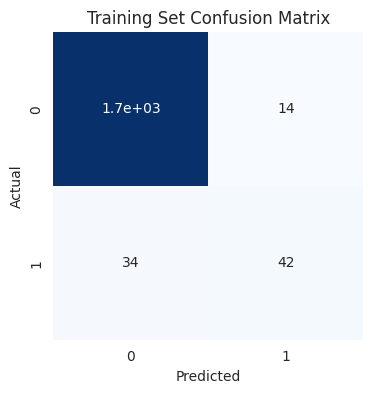

In [243]:
_, _, _, _, cm = evaluate_classification_model(model, X_test, y_test, False)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False)
plt.title('Training Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

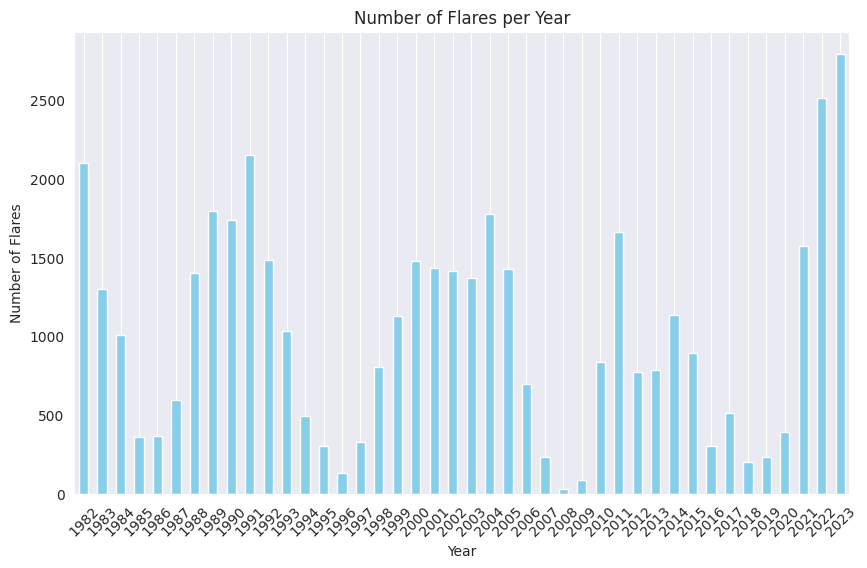

In [145]:
year_counts = df_flares['Date'].dt.year.value_counts().sort_index()

plt.figure(figsize=(10, 6))
year_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Flares per Year')
plt.xlabel('Year')
plt.ylabel('Number of Flares')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.show()

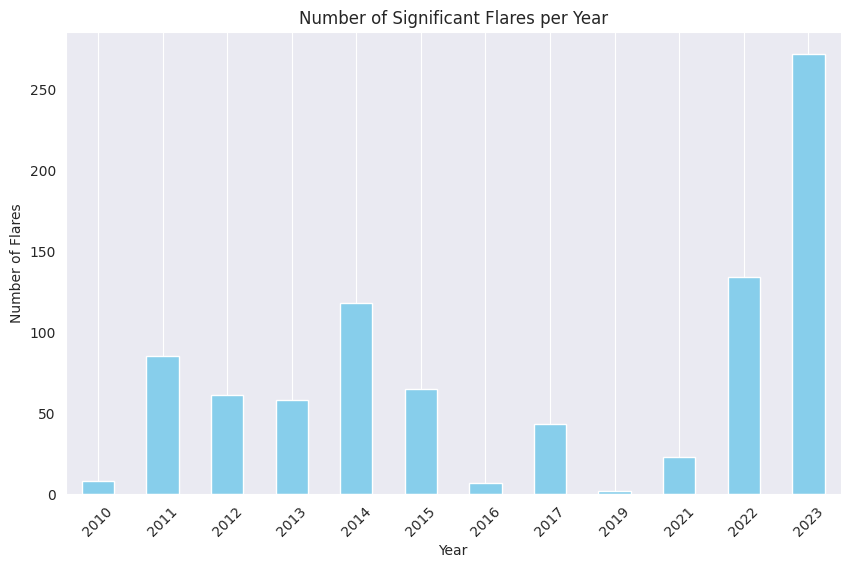

In [146]:
year_counts = df_merged[df_merged['X-ray Binary'] == 1]['Date'].dt.year.value_counts().sort_index()

plt.figure(figsize=(10, 6))
year_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Significant Flares per Year')
plt.xlabel('Year')
plt.ylabel('Number of Flares')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.show()

In [88]:
df_merged.shape

(25865, 119)

In [271]:
df_merged[df_merged['X-ray Binary'] == 0].shape[0], df_merged[df_merged['X-ray Binary'] == 1].shape[0]

(24989, 876)

In [264]:
tmp_filtered_df_merged = df_merged[df_merged['X-ray Binary'] == 0].drop_duplicates(subset=['Region', 'Date'])

tmp_filtered_df_merged.shape

(18199, 119)

In [273]:
df_merged[df_merged['X-ray Binary'] == 1].drop_duplicates(subset=['Region", "fDate']).shape[0]

562

In [275]:
df_merged[df_merged['X-ray All Flare'] == 1][col_1_for_ml].isnull().sum().max()

91

In [277]:
X = pd.concat([tmp_filtered_df_merged[col_1_for_ml],
              df_merged[df_merged['X-ray Binary'] == 1][col_1_for_ml]])
y = pd.concat([tmp_filtered_df_merged['X-ray Binary'],
              df_merged[df_merged['X-ray Binary'] == 1]['X-ray Binary']])

# y = pd.concat(tmp_df[tmp_df['X-ray All Flare'] != 0]['X-ray Binary'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9554390563564875
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      3640
           1       0.51      0.55      0.53       175

    accuracy                           0.96      3815
   macro avg       0.75      0.76      0.75      3815
weighted avg       0.96      0.96      0.96      3815


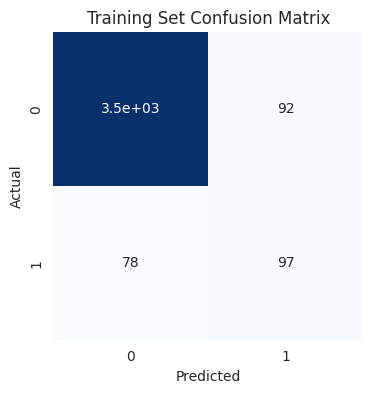

In [280]:
_, _, _, _, cm = evaluate_classification_model(clf, X_test, y_test, False)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False)
plt.title('Training Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

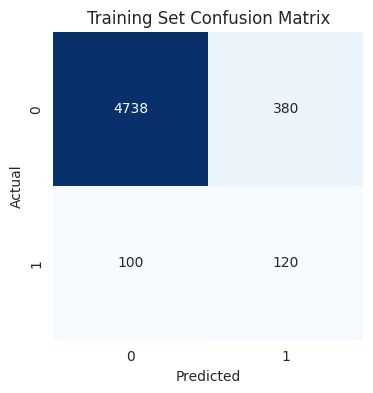

In [304]:
_, _, _, _, cm = evaluate_classification_model(clf, X_test, y_test, False)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Training Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [330]:
df_for_ml = df_merged[[
  'MEANGAM', # inclination angle, gamma
  'MEANGBZ', 'MEANGBH', 'MEANGBT',  # field gradient
  'TOTPOT', 'MEANPOT',  # photospheric magnetic energy density
  'MEANJZD',  # vertical current density
  'ABSNJZH', 'MEANJZH', # current helicity
  'TOTUSJH',  # unsigned current helicity
  
  # TODO: need to fix this
  # 'ERRTAI',   # Absolute value of the net current helicity
  # 'ERRTUI', # Total unsigned current helicity
  # 'ERRMIH', # Mean current helicity
  'MEANALP',  # twist parameter
  'MEANSHR',  # shear angle for B_total
  'TOTUSJZ',  # unsigned vertical current
  
  'SAVNCPP',  # Net Currents Per Polarity
  'SHRGT45',  # shear angle greater than 45 as a percent of total area
  'R_VALUE',  # Unsigned Flux R (Schrijver, 2007)
  'OMEGA_DT', # Rotation rate over disk transit
  # 'NPIX',     # Number of pixels within the patch
  'SIZE',     # image in micro-hemisphere
  'AREA',     # De-projected area of patch on sphere in micro-hemisphere
  # 'NACR',     #  Number of active pixels in patch
  'AREA_ACR', #'SIZE_ACR' , # active pixels on image in micro-hemisphere
  'MTOT', 'MNET', 'MPOS_TOT', 'MNEG_TOT', 'MMEAN', 'MSTDEV', 'MSKEW', 'MKURT',  # LoS flux
  
  # Stonyhurst latitude
  'LAT_FWT', 'LON_FWT', #'LAT_FWTPOS', 'LON_FWTPOS', 'LAT_FWTNEG', 'LON_FWTNEG',
  # 'INVBLAVE', 'MEANGBL', # line-of-sight field gradient
  # 'INVBBAVE', # field strength over processed pixels

  # Number of pixels that contributed to the calculation of MEANGBL and USFLUXL
  # 'INVNPRCS', 'CMASKL',

  # 'INVNCNVG', # Numer of pixels at which ME VFISV converged
  # 'AMBGMTRY', # Flag determining whether to use planar or spherical geometry
  # 'AMBPATCH', 'AMBWEAK',  # flag for disambiguation
  # 'DOFFSET' # Constant value added to the noise mask for disambiguation.
  # 'AMBNGROW', # Number of pixels by which to grow eroded map
  # 'AMBNPAD',  # Padding to use in potential field calculation
  # 'AMBNTX', 'AMBNTY', # Number of tiles for potential field calculation
  
  # 'AMBSEED',  # Input random number seed
  # 'AMBTFCTR', # Input factor to reduce temperature
  # 'CMASK',  # Number of pixels that contributed to the spaceweather calculation
  'X-ray Binary', 'X-ray Distinct', 'X-ray Grouped']].dropna()


df_for_ml['TOTUSJZ'] = np.log(df_for_ml['TOTUSJZ'])
df_for_ml['MTOT'] = np.log(df_for_ml['MTOT'])
df_for_ml['MPOS_TOT'] = np.log(df_for_ml['MPOS_TOT'])
df_for_ml['MNEG_TOT'] = np.log(df_for_ml['MNEG_TOT'])
df_for_ml['MNET'] = np.log(df_for_ml['MNET'])
df_for_ml['TOTPOT'] = np.log(df_for_ml['TOTPOT'])
df_for_ml['SAVNCPP'] = np.log(df_for_ml['SAVNCPP'])


# df_for_ml = df_for_ml.dropna()

df_for_ml = df_for_ml.replace([np.inf, -np.inf], np.nan).dropna()
df_for_ml.shape

/home/debashis/works/other-people/SHARPs/env/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/debashis/works/other-people/SHARPs/env/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(15153, 33)

In [322]:
df_for_ml

,MEANGAM,MEANGBZ,MEANGBH,TOTPOT,MEANJZD,ABSNJZH,TOTUSJH,MEANALP,MEANSHR,TOTUSJZ,...,MNEG_TOT,MMEAN,MSTDEV,MSKEW,MKURT,LAT_FWT,LON_FWT,X-ray Binary,X-ray Distinct,X-ray Grouped
0,23.844,75.671,30.892,1.874664e+22,-0.129899,17.197,298.638,-0.006016,17.808,29.402716,...,12.110207,28.963026,96.135506,0.989668,5.176516,24.177683,-65.205566,0,2,1
1,23.844,75.671,30.892,1.874664e+22,-0.129899,17.197,298.638,-0.006016,17.808,29.402716,...,12.110207,28.963026,96.135506,0.989668,5.176516,24.177683,-65.205566,0,2,1
4,29.506,117.547,46.249,2.313961e+22,0.125124,5.913,322.632,-0.004773,24.692,29.592852,...,14.104051,6.808321,115.512276,-0.159619,15.803296,23.811779,-25.096449,0,0,0
13,34.426,152.501,62.038,2.859746e+21,0.864686,14.400,71.477,-0.047383,24.329,27.993103,...,12.946764,5.278372,115.099701,-0.360438,19.413486,-26.296352,8.540434,0,2,1
15,23.015,71.843,26.375,2.081197e+22,0.042337,21.990,338.201,0.004576,18.031,29.665992,...,13.139675,2.480918,98.797569,-0.133825,3.621419,-19.253683,-64.808563,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32922,34.609,80.256,35.222,1.452887e+23,0.182207,19.775,846.163,0.001256,26.916,30.364575,...,12.733441,42.910580,136.932831,0.722446,3.536355,6.642423,75.659233,0,3,1
32923,34.609,80.256,35.222,1.452887e+23,0.182207,19.775,846.163,0.001256,26.916,30.364575,...,12.733441,42.910580,136.932831,0.722446,3.536355,6.642423,75.659233,0,3,1
32924,34.609,80.256,35.222,1.452887e+23,0.182207,19.775,846.163,0.001256,26.916,30.364575,...,12.733441,42.910580,136.932831,0.722446,3.536355,6.642423,75.659233,0,3,1
32928,29.843,130.853,49.949,5.657186e+21,0.767667,7.799,99.594,0.007271,23.647,28.384971,...,13.384993,0.153213,108.692841,-0.851413,14.766701,-4.856016,31.698223,0,0,0


In [302]:
X = df_for_ml.drop(['X-ray Binary', 'X-ray Distinct', 'X-ray Grouped'], axis=1)
y = df_for_ml['X-ray Binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

for mk in ["LgR", "DTC", "RFC", "GBC"]:
  model = train_model(mk, X_train_scaled, y_train)
  print_metrics(evaluate_classification_model(model, X_test_scaled, y_test))

Accuracy:97.45, Precision: 0.0, Recall: 0.0, F1: 0.0
Accuracy:96.66, Precision: 15.79, Recall: 10.17, F1: 10.17
Accuracy:96.88, Precision: 24.32, Recall: 15.38, F1: 15.38
Accuracy:97.07, Precision: 19.05, Recall: 7.92, F1: 7.92


In [309]:
X = df_for_ml.drop(['X-ray Binary', 'X-ray Distinct', 'X-ray Grouped'], axis=1)
y = df_for_ml['X-ray Distinct']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

for mk in ["LgR", "DTC", "RFC", "GBC"]:
  model = train_model(mk, X_train_scaled, y_train)
  print_metrics(evaluate_classification_model(model, X_test_scaled, y_test, False))

/home/debashis/works/other-people/SHARPs/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/debashis/works/other-people/SHARPs/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy:68.91, Precision: 27.72, Recall: 23.77, F1: 23.77


/home/debashis/works/other-people/SHARPs/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy:74.29, Precision: 36.2, Recall: 35.63, F1: 35.63


/home/debashis/works/other-people/SHARPs/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy:78.41, Precision: 40.11, Recall: 38.42, F1: 38.42
Accuracy:72.31, Precision: 37.27, Recall: 30.67, F1: 30.67


/home/debashis/works/other-people/SHARPs/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [310]:
X = df_for_ml.drop(['X-ray Binary', 'X-ray Distinct', 'X-ray Grouped'], axis=1)
y = df_for_ml['X-ray Grouped']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

for mk in ["LgR", "DTC", "RFC", "GBC"]:
  model = train_model(mk, X_train_scaled, y_train)
  print_metrics(evaluate_classification_model(model, X_test_scaled, y_test, False))

/home/debashis/works/other-people/SHARPs/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/debashis/works/other-people/SHARPs/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy:72.18, Precision: 34.79, Recall: 34.98, F1: 34.98


/home/debashis/works/other-people/SHARPs/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy:77.47, Precision: 42.01, Recall: 41.15, F1: 41.15


/home/debashis/works/other-people/SHARPs/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy:80.99, Precision: 44.76, Recall: 43.63, F1: 43.63
Accuracy:75.42, Precision: 44.05, Recall: 39.5, F1: 39.5


/home/debashis/works/other-people/SHARPs/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [300]:
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9047464239271782
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      2984
           1       0.16      0.51      0.24        92

    accuracy                           0.90      3076
   macro avg       0.57      0.71      0.60      3076
weighted avg       0.96      0.90      0.93      3076


/home/debashis/works/other-people/SHARPs/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


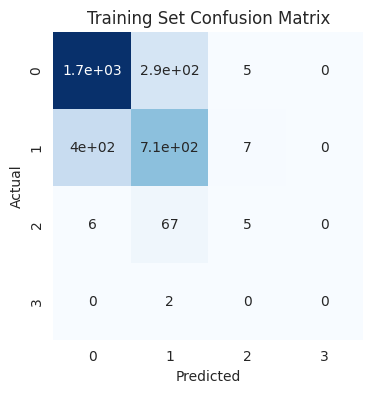

In [312]:
_, _, _, _, cm = evaluate_classification_model(model, X_test_scaled, y_test, False)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False)
plt.title('Training Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [331]:
X = df_for_ml[['ABSNJZH','AREA_ACR','MEANALP','MEANGAM','MEANGBH','MEANGBT','MEANGBZ','MEANJZD','MEANJZH','MEANPOT','MEANSHR','R_VALUE','SAVNCPP','SHRGT45','TOTPOT','TOTUSJH','TOTUSJZ']]
y = df_for_ml['X-ray Binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      2937
           1       0.17      0.48      0.25        94

    accuracy                           0.91      3031
   macro avg       0.57      0.70      0.60      3031
weighted avg       0.96      0.91      0.93      3031


In [344]:
testin_df = pd.read_csv("hmi.sharp_cea_720s.csv", low_memory=False)

In [352]:
# testin_df[testin_df['NOAA_AR'] == 11069][['T_REC', 'TOTUSJH', 'TOTUSJZ', 'TOTPOT', 'MEANPOT']]
testin_df[testin_df['MEANPOT'] > 5043][['T_REC', 'TOTUSJH', 'TOTUSJZ', 'TOTPOT', 'MEANPOT']]

,T_REC,TOTUSJH,TOTUSJZ,TOTPOT,MEANPOT
12,2010.05.03_00:00:00_TAI,57.896,1.234904e+12,5.938522e+21,6734.383
22,2010.05.05_00:00:00_TAI,722.848,1.223547e+13,9.194835e+22,6415.482
27,2010.05.06_00:00:00_TAI,789.497,1.362523e+13,1.262362e+23,6040.171
64,2010.05.22_00:00:00_TAI,388.111,8.017016e+12,9.220335e+22,9604.082
68,2010.05.23_00:00:00_TAI,585.784,1.273046e+13,1.721010e+23,10802.750
...,...,...,...,...,...
32637,2023.12.29_00:00:00_TAI,850.454,1.788813e+13,3.131833e+23,10517.010
32638,2023.12.29_00:00:00_TAI,1037.491,2.064462e+13,1.579310e+23,5399.809
32653,2023.12.30_00:00:00_TAI,942.052,1.994722e+13,2.665505e+23,7294.002
32666,2023.12.31_00:00:00_TAI,817.475,1.473819e+13,2.614478e+23,8173.154


# Checking missing data after merging

In [194]:
_another_tmp_df = pd.read_csv("flares-processed-2.csv").dropna()

In [195]:
_another_tmp_df['Date'] = pd.to_datetime(_another_tmp_df[['Year', 'Month', 'Day']])

In [196]:
_another_tmp_df = _another_tmp_df[_another_tmp_df['Date'] > '2010-05-01']

In [210]:
_another_tmp_df[['Region', 'Date']].info()

In [223]:
_tmp_df1 = df[['NOAA_ARS', 'T_REC']]
_tmp_df1.rename(columns={'NOAA_ARS': 'Region', 'T_REC': 'Date'}, inplace=True)
_tmp_df1['Date'] = pd.to_datetime(_tmp_df1['Date'])
_tmp_df1['Region'] = _tmp_df1['Region'].astype(int)
_another_tmp_df['Region'] = _another_tmp_df['Region'].astype(int)
_tmp_merged = pd.merge(_tmp_df1, _another_tmp_df[['Region', 'Date', 'Year']], on=['Region', 'Date'], how='outer', indicator=True)
df_not_matching = _tmp_merged[_tmp_merged['_merge'] != 'both']
df1_not_matching = df_not_matching[df_not_matching['_merge'] == 'left_only'].drop(columns=['_merge'])
df2_not_matching = df_not_matching[df_not_matching['_merge'] == 'right_only'].drop(columns=['_merge'])

/tmp/ipykernel_447042/3822141721.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _tmp_df1.rename(columns={'NOAA_ARS': 'Region', 'T_REC': 'Date'}, inplace=True)
/tmp/ipykernel_447042/3822141721.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _tmp_df1['Date'] = pd.to_datetime(_tmp_df1['Date'])
/tmp/ipykernel_447042/3822141721.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [220]:
df1_not_matching.shape[0], df2_not_matching.shape[0]

(19831, 1416)

In [221]:
df[df['NOAA_ARS'] == '12804'][['NOAA_ARS', 'T_REC']]

,NOAA_ARS,T_REC
16273,12804,2021-02-23
16276,12804,2021-02-24
16279,12804,2021-02-25
16282,12804,2021-02-26
16285,12804,2021-02-27
16288,12804,2021-02-28
16290,12804,2021-03-01


In [226]:
_another_tmp_df[_another_tmp_df['Region'] == 12804][['Region', 'Date']]

,Region,Date
66148,12804,2021-02-22
66149,12804,2021-02-22
66150,12804,2021-02-22
66151,12804,2021-02-23
66154,12804,2021-02-23
66155,12804,2021-02-23
66156,12804,2021-02-23
66158,12804,2021-02-23
66159,12804,2021-02-23
66160,12804,2021-02-24


In [231]:
_tmp_merged.dropna().shape

(14519, 4)

In [230]:
df.shape

(24701, 63)

In [229]:
len(set(df2_not_matching['Region'].unique()) - set(df1_not_matching['Region'].unique()))

96